In [119]:
import ROOT as r
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [120]:
#Returns the time vs. x and time vs. y data from the pixel_hits. The ATAR is made up of sheets that contain alternating horizontal or vertical strips with npixels_per_plane.
#If npixels_per_plane were 100, for instance, 100036 would represent plate 1, 36 / 100 in x, 100161 would represent plate 2, 61 / 100 in y, etc. The output for each of 
#x and y is an n x 2 matrix, where the first column contains the times corresponding to the coordinate values in the second column.
#Also extract the z (plane #) vs. time data. The third element of the tuples contained in this list and the x and y lists will contain corresponding colors to represent
#when particles have decayed.
def get_event(tree):
    #Print an entry with a pion decay in flight.
    for i, e in enumerate(tree):
        #----------> Change this to adjust which type of events we want to view. <----------
        if e.pion_decay == 1 and e.pion_dar == 1:
            print("Index of event in tree: " + str(i))
            tree.GetEntry(i)
            break
    #Store pixel hits for the entry printed above in which a pion didn't decay at rest.
    pixel_times = tree.pixel_time
    pixel_hits = tree.pixel_hits
    pixel_pdg = tree.pixel_pdg
    pixel_edep = tree.pixel_edep
    
    #Create empty data structures for storing x vs. z, y vs. z, z vs. t, and Energy deposited vs. z data.
    npixels_per_plane = 100
    zxc_data = []
    zyc_data = []
    tzc_data = []
    zE_data = []

    #Extract x vs. t, y vs. t, and z vs. t data. Also add indexed color coding to represent different particles.
    for i in range(pixel_hits.size()):
        plane = int(np.floor((pixel_hits[i] - 1 - 100_000) / npixels_per_plane))

        cur_val = (pixel_hits[i] - 1) % npixels_per_plane
        cur_time = pixel_times[i]

        if pixel_pdg[i] == 211:
            cur_color = "r"     # +Pion
        elif pixel_pdg[i] == -11:
            cur_color = "b"     # Positron
        elif pixel_pdg[i] == 11:
            cur_color = "g"     # Electron
        elif pixel_pdg[i] == -13:
            cur_color = "y"     # +Muon
        elif pixel_pdg[i] == 13:
            cur_color = "p"     # -Muon

        tzc_data.append((cur_time, plane, cur_color))
        zE_data.append((plane, pixel_edep[i]))

        if(plane % 2 == 0):
            zxc_data.append((plane, cur_val, cur_color))
        else:
            zyc_data.append((plane, cur_val, cur_color))
    
    return (zxc_data, zyc_data, tzc_data, zE_data)

In [121]:
#Show some useful parameters describing our event.
def display_event(zxc_data, zyc_data, tzc_data, zE_data):
    print("Length of zxc_data: " + str(len(zxc_data)))
    print("Length of zyc_data: " + str(len(zyc_data)))
    print("Length of tzc_data: " + str(len(tzc_data)))
    print("Length of zE_data: " + str(len(zE_data)))
    print("zxc_data: " + str(zxc_data))
    print("zE_data: " + str(zE_data))

In [126]:
#For each color in a list of color labels for different particles, plot the corresponding data.
def plot_with_color_legend(data):
    for color in ["r", "b", "g", "y", "p"]:
        #Include only points of 1 color each loop. This makes it easier to configure the legend.
        curpoints = []
        curindex = 0
        for i in data:
            if i[2] == color:
                curpoints.append(i)
        
        #Only plot if the current particle decay type was present in the data.
        if len(curpoints) != 0:
            if color == "r":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Pion")
            elif color == "b":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Positron")
            elif color == "g":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Electron")
            elif color == "y":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Antimuon")
            elif color == "p":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Muon")


#Plot x vs. t, y vs. t, and z vs. t data from our event. The graphs will show the color-coding system used to represent different particles.
#Display 0 to num_planes on plots including the z variable.
def plot_event(zxc_data, zyc_data, tzc_data, zE_data, num_planes):

    plt.figure(figsize = (24, 5))

    plt.subplot(1,4,1)
    plot_with_color_legend(zxc_data)
    plt.title("x vs. z")
    plt.xlabel("z (plane number)")
    plt.ylabel("x (pix)")
    plt.legend()
    plt.xlim(0, num_planes)
    plt.ylim(0, 100)

    plt.subplot(1,4,2)
    plot_with_color_legend(zyc_data)
    plt.title("y vs. z")
    plt.xlabel("z (plane number)")
    plt.ylabel("y (pix)")
    plt.xlim(0, num_planes)
    plt.ylim(0, 100)

    plt.subplot(1,4,3)
    plot_with_color_legend(tzc_data)
    plt.title("z vs. t")
    plt.xlabel("t (ns)")
    plt.ylabel("z (plane number)")
    plt.ylim(0, num_planes)

    plt.subplot(1,4,4)
    plt.scatter([i[0] for i in zE_data], [i[1] for i in zE_data], 10)
    plt.title("ATAR Energy Deposition Per Plane vs. z")
    plt.xlabel("z (plane number)")
    plt.ylabel("Energy (MeV / plane)")
    #plt.xlim(0, num_planes)

    plt.subplots_adjust(left = 0.1,
                        bottom = 0.1, 
                        right = 0.9, 
                        top = 0.9, 
                        wspace = 0.5, 
                        hspace = 0.4)

In [130]:
#Combines the functions we created above to give a visualization of the first event in which
#there is a specified condition (see above code; at the moment, first no decay / decay in flight).
def event_visualization(tree):
    zx, zy, tz, zE = get_event(tree)
    display_event(zx, zy, tz, zE)
    plot_event(zx, zy, tz, zE, 40)

['pixel_hits', 'pixel_pdg', 'pixel_edep', 'pixel_time', 'nhit', 'has_pion', 'pion_decay', 'pion_dar', 'has_muon', 'muon_decay', 'muon_dar', 'has_positron', 'pion_total_edep', 'muon_total_edep', 'pos_total_edep', 'has_excited_nucleus']


Index of event in tree: 0
Length of zxc_data: 52
Length of zyc_data: 56
Length of tzc_data: 108
Length of zE_data: 108
zxc_data: [(0, 35, 'r'), (2, 35, 'r'), (4, 35, 'r'), (6, 35, 'r'), (8, 35, 'r'), (10, 35, 'r'), (12, 35, 'r'), (14, 35, 'r'), (16, 35, 'r'), (18, 35, 'r'), (20, 35, 'r'), (22, 35, 'r'), (24, 35, 'r'), (26, 35, 'r'), (28, 35, 'r'), (30, 35, 'r'), (32, 35, 'r'), (32, 35, 'b'), (32, 36, 'b'), (30, 38, 'b'), (30, 39, 'b'), (28, 40, 'b'), (28, 41, 'b'), (26, 42, 'b'), (26, 43, 'b'), (26, 44, 'b'), (24, 45, 'b'), (24, 46, 'b'), (22, 47, 'b'), (22, 48, 'b'), (20, 49, 'b'), (20, 50, 'b'), (20, 51, 'b'), (18, 52, 'b'), (18, 53, 'b'), (16, 54, 'b'), (16, 55, 'b'), (14, 56, 'b'), (14, 57, 'b'), (12, 58, 'b'), (12, 59, 'b'), (12, 60, 'b'), (10, 61,

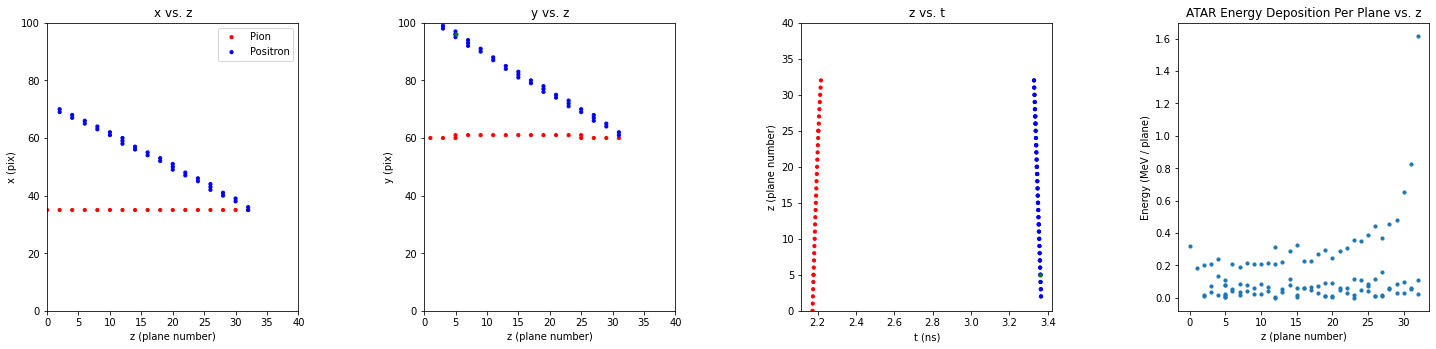

In [131]:
#Explore pion --> e data.
f = r.TFile("pienux_out_stripped.root")
t = f.Get("atar")
print([x.GetName() for x in t.GetListOfBranches()])
print("\n")

event_visualization(t)

Index of event in tree: 0
Length of zxc_data: 25
Length of zyc_data: 23
Length of tzc_data: 48
Length of zE_data: 48
zxc_data: [(0, 34, 'r'), (2, 34, 'r'), (4, 34, 'r'), (6, 33, 'r'), (8, 33, 'r'), (10, 33, 'r'), (12, 33, 'r'), (14, 33, 'r'), (16, 35, 'y'), (16, 36, 'y'), (16, 37, 'y'), (16, 37, 'b'), (16, 36, 'b'), (14, 36, 'b'), (14, 35, 'b'), (12, 35, 'b'), (12, 34, 'b'), (10, 34, 'b'), (10, 33, 'b'), (8, 33, 'b'), (6, 32, 'b'), (4, 32, 'b'), (4, 31, 'b'), (2, 31, 'b'), (0, 31, 'b')]
zE_data: [(0, 0.3025445700180494), (1, 0.24027557116663817), (2, 0.3570055433887048), (3, 0.3212344729021917), (4, 0.2939724991989609), (5, 0.3391503553112243), (6, 0.34105191964725856), (7, 0.3491820600806537), (8, 0.39057991237293416), (9, 0.41551332197334906), (10, 0.4277446771489626), (11, 0.42356091047076067), (12, 0.5690451479895734), (13, 0.652216326830818), (14, 0.8519448504151363), (15, 1.4260943137525561), (15, 0.44174056179552024), (15, 1.3393900296259917), (16, 0.027228716116649166), (16, 1.

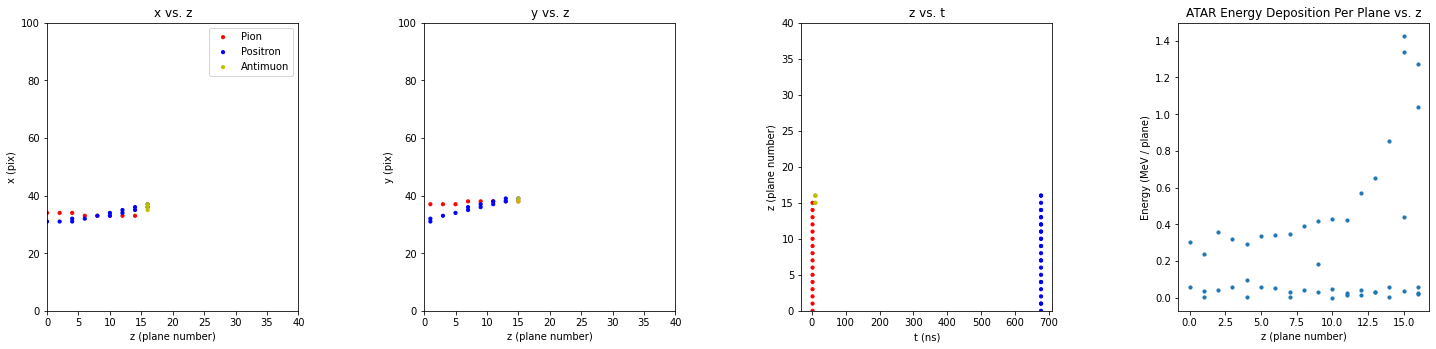

In [132]:
#Explore pion --> muon --> e data.
f = r.TFile("pienux_out_stripped_muons.root")
t = f.Get("atar")
event_visualization(t)